### Libarires

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn import metrics
df=pd.read_csv('/content/Original.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (86928, 5)


,Date,Time,Temp,Humidity,Active_Power
0,1/31/2006,1:00:00 AM,11.6000,98,732.8000
1,1/31/2006,2:00:00 AM,11.6000,98,711.1000
2,1/31/2006,3:00:00 AM,21.8800,91,706.5000
3,1/31/2006,4:00:00 AM,24.4100,79,711.7000
4,1/31/2006,5:00:00 AM,25.6800,75,824.6000


### Data Prepration

In [3]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Active_Power'] = pd.to_numeric(df['Active_Power'], errors='coerce')
df = df.dropna(subset=['Active_Power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Active_Power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (86928, 7)
The time series starts from:  2006-01-31 00:00:00
The time series ends on:  2015-12-31 23:00:00


In [4]:
df

,date_time,Active_Power,year,quarter,month,day,weekday
0,2006-01-31 00:00:00,789.7000,2006,1,1,31,1
1,2006-01-31 01:00:00,732.8000,2006,1,1,31,1
2,2006-01-31 02:00:00,711.1000,2006,1,1,31,1
3,2006-01-31 03:00:00,706.5000,2006,1,1,31,1
4,2006-01-31 04:00:00,711.7000,2006,1,1,31,1
...,...,...,...,...,...,...,...
86923,2015-12-31 19:00:00,2198.2000,2015,4,12,31,1
86924,2015-12-31 20:00:00,2082.7000,2015,4,12,31,1
86925,2015-12-31 21:00:00,1823.6000,2015,4,12,31,1
86926,2015-12-31 22:00:00,1614.3000,2015,4,12,31,1


### Data Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86928 entries, 0 to 86927
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     86928 non-null  datetime64[ns]
 1   Active_Power  86928 non-null  float64       
 2   year          86928 non-null  int64         
 3   quarter       86928 non-null  int64         
 4   month         86928 non-null  int64         
 5   day           86928 non-null  int64         
 6   weekday       86928 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 4.6 MB


### Data Vizulization

Kurtosis of normal distribution: -0.5080127300691748
Skewness of normal distribution: 0.34342776775097317


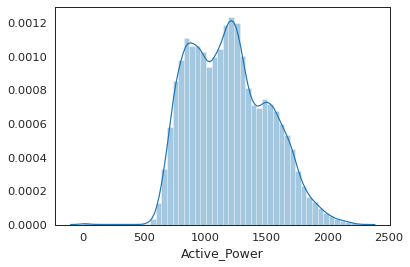

In [6]:
sns.distplot(df.Active_Power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Active_Power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Active_Power)))

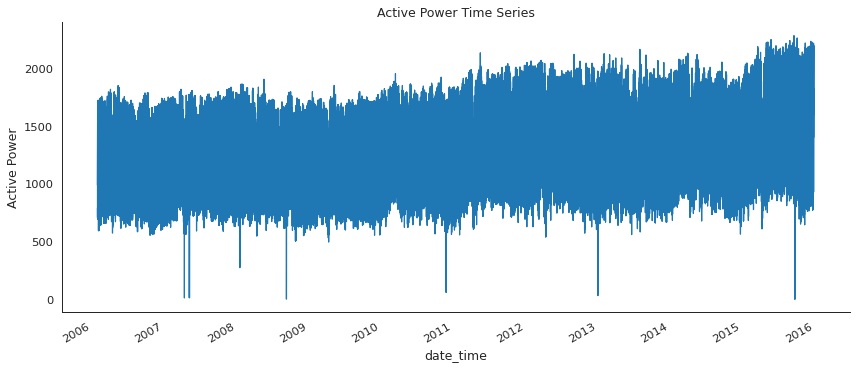

In [7]:
df1=df.loc[:,['date_time','Active_Power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Active Power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Active Power Time Series')
sns.despine(top=True)
plt.show();

### Boxplot

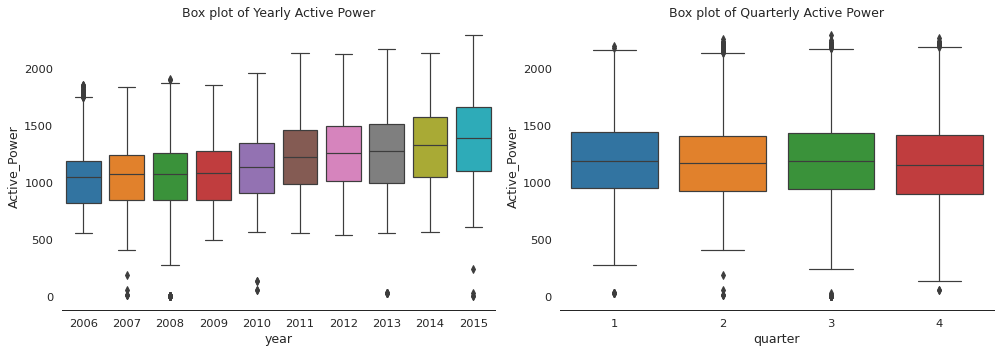

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Active_Power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Active_Power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Active Power')
sns.despine(left=True)
plt.tight_layout();

### Active Power Distribuiton of Data

,count,mean,std,min,25%,50%,75%,max
Active_Power,86928.0000,1190.8515,319.8326,0.0000,928.4000,1172.1000,1421.3000,2283.4000


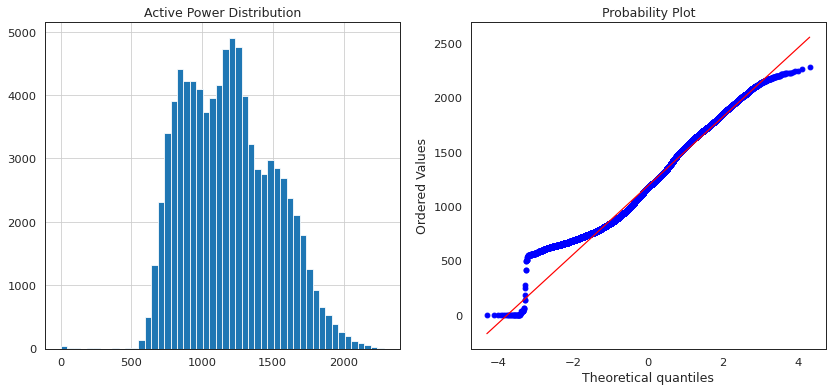

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Active_Power'].hist(bins=50)
plt.title('Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Active_Power'], plot=plt);
df1.describe().T

### Resampled Active Power Data

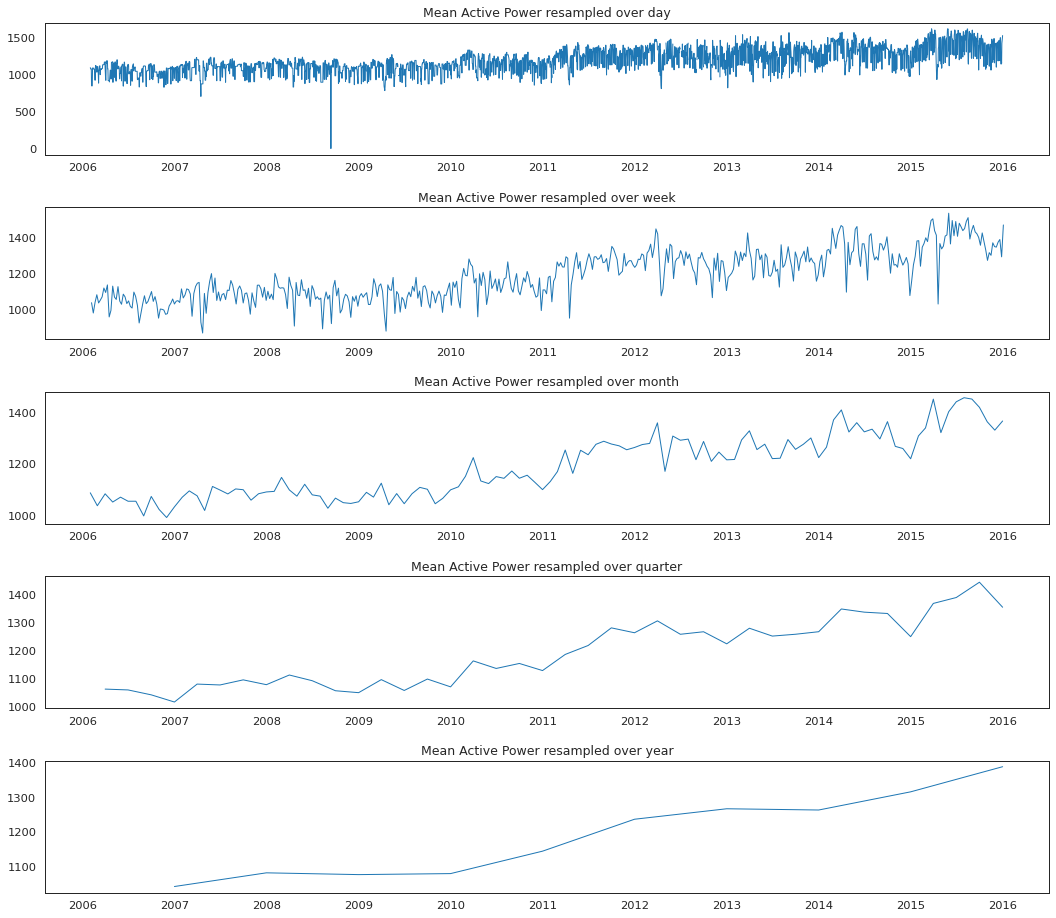

In [10]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Active_Power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Active Power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Active_Power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Active Power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Active_Power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Active Power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Active_Power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Active Power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Active_Power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Active Power resampled over year')
ax5.tick_params(axis='both', which='major');

## Model

Model Used:

* CNN (Convolution Neural Network)
* Simple RNN (Simple Recurruent Nueral Network)
* LSTM (Long short-term memory Recurrent Nueral Network)

### For each Model
* Regulizaer = "Relu"
* Adam Optimzier(Learning Rate) = 0.01

### Train and Test Data

In [11]:
df1=df.drop(['year','quarter','month','day','weekday'],axis=1) 
df1

,date_time,Active_Power
0,2006-01-31 00:00:00,789.7000
1,2006-01-31 01:00:00,732.8000
2,2006-01-31 02:00:00,711.1000
3,2006-01-31 03:00:00,706.5000
4,2006-01-31 04:00:00,711.7000
...,...,...
86923,2015-12-31 19:00:00,2198.2000
86924,2015-12-31 20:00:00,2082.7000
86925,2015-12-31 21:00:00,1823.6000
86926,2015-12-31 22:00:00,1614.3000


In [12]:
df1 = df1.set_index("date_time")
df1.head()

,Active_Power
date_time,
2006-01-31 00:00:00,789.7000
2006-01-31 01:00:00,732.8000
2006-01-31 02:00:00,711.1000
2006-01-31 03:00:00,706.5000
2006-01-31 04:00:00,711.7000


### Split dataset

In [13]:
train_data = df1[:len(df)-12]
test_data = df1[len(df)-12:]

### Min Max Scaler of Data 

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [15]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

### The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples, ready to train deep learning models.

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

### Convolution Neural Network

In [17]:
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_input, n_features)))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(Flatten())
CNN.add(Dense(50, activation='relu'))
CNN.add(Dense(1))
CNN.compile(optimizer='adam', loss='mse')

Model Summary

In [18]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                16050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


### monitor validation progress


In [21]:
early = EarlyStopping(mode = "min", patience = 3)
callbacks_list = [early]
    
CNN.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

### Run Model

In [22]:
history = CNN.fit_generator(generator,epochs = 10, callbacks=callbacks_list)

Epoch 1/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0043 - mse: 0.0043
Epoch 2/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0025 - mse: 0.0025
Epoch 3/10
86904/86904 [==============================] - 106s 1ms/step - loss: 0.0022 - mse: 0.0022
Epoch 4/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0020 - mse: 0.0020
Epoch 5/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0019 - mse: 0.0019
Epoch 6/10
86904/86904 [==============================] - 105s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 7/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0018 - mse: 0.0018
Epoch 8/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0017 - mse: 0.0017
Epoch 9/10
86904/86904 [==============================] - 105s 1ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/10
86904/86904 [==============================] - 103s 1ms/step - loss: 0.0017 - m

### Plot Loss

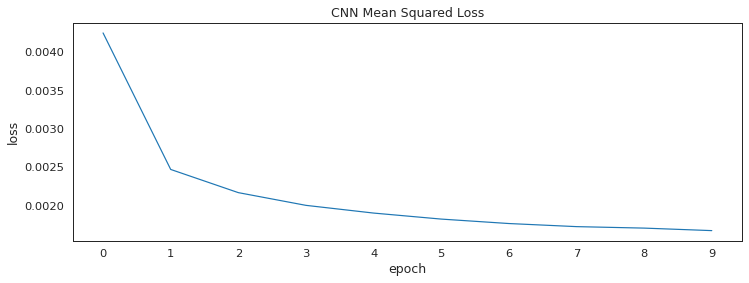

In [24]:
losses_CNN = CNN.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.title('CNN Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_CNN)),losses_CNN);

### Prediction 

In [26]:
CNN_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    CNN_pred = CNN.predict(current_batch)[0]
    CNN_predictions_scaled.append(CNN_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[CNN_pred]],axis=1)

### Transform Values(Scale the Value Back to its Orginal Form)

In [32]:
CNN_predictions = scaler.inverse_transform(CNN_predictions_scaled)

### Store the data and Visualization

In [39]:
test_data['CNN_Predictions'] = CNN_predictions
test_data
true_pred = test_data['Active_Power']

### MSE and RMSE

In [45]:
mae = metrics.mean_absolute_error(true_pred,CNN_predictions)
mse = metrics.mean_squared_error(true_pred, CNN_predictions)
rmse = np.sqrt(metrics.mean_squared_error(true_pred, CNN_predictions))
r2_square = metrics.r2_score(true_pred, CNN_predictions)
print('Total Mean Absolute Error:', mae)
print('Total Mean Squared Error:', mse)
print('Total Root Mean Squared Error:', rmse)
print('Total R2 Square', r2_square)

Total Mean Absolute Error: 74.90788741807141
Total Mean Squared Error: 9810.865519687197
Total Root Mean Squared Error: 99.0498133248478
Total R2 Square 0.7593150647335754


### Visualising the results


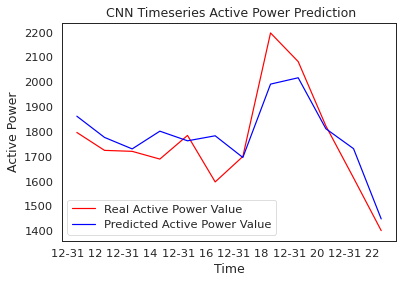

In [46]:
plt.plot(test_data.Active_Power, color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['CNN_Predictions'], color = 'blue', label = 'Predicted Active Power Value')
plt.title(' CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### Vizulization of Specific Time

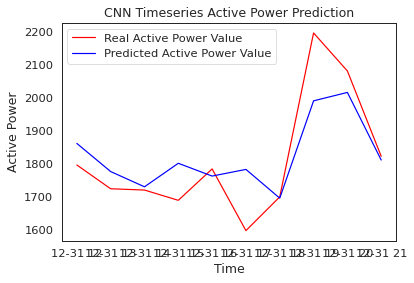

In [47]:
plt.plot(test_data.Active_Power[0:10], color = 'red', label = 'Real Active Power Value')
plt.plot(test_data.CNN_Predictions[0:10], color = 'blue', label = 'Predicted Active Power Value')
plt.title('CNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### Simple RNN 

In [48]:
RNN = Sequential()
RNN.add(SimpleRNN(45, input_shape = (n_input, n_features), activation = 'relu'))
RNN.add(Dropout(0.15))
RNN.add(Dense(45, activation = 'relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(45, activation = 'relu'))
RNN.add(Dropout(0.1))
RNN.add(Dense(1, activation='linear'))

### Summary

In [49]:
RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 45)                2115      
_________________________________________________________________
dropout (Dropout)            (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 45)                2070      
_________________________________________________________________
dropout_2 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [50]:
early = EarlyStopping(mode = "min", patience = 3)
callbacks_list = [early]
    
RNN.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

### Run Model

In [51]:
history = RNN.fit_generator(generator,epochs =10,callbacks = callbacks_list)

Epoch 1/10
86904/86904 [==============================] - 258s 3ms/step - loss: 0.0034 - mse: 0.0034
Epoch 2/10
86904/86904 [==============================] - 258s 3ms/step - loss: 0.0023 - mse: 0.0023
Epoch 3/10
86904/86904 [==============================] - 251s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 4/10
86904/86904 [==============================] - 252s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 5/10
86904/86904 [==============================] - 257s 3ms/step - loss: 0.0020 - mse: 0.0020
Epoch 6/10
86904/86904 [==============================] - 261s 3ms/step - loss: 0.0020 - mse: 0.0020
Epoch 7/10
86904/86904 [==============================] - 258s 3ms/step - loss: 0.0020 - mse: 0.0020
Epoch 8/10
86904/86904 [==============================] - 265s 3ms/step - loss: 0.0019 - mse: 0.0019
Epoch 9/10
86904/86904 [==============================] - 267s 3ms/step - loss: 0.0019 - mse: 0.0019
Epoch 10/10
86904/86904 [==============================] - 264s 3ms/step - loss: 0.0019 - m

### Plot

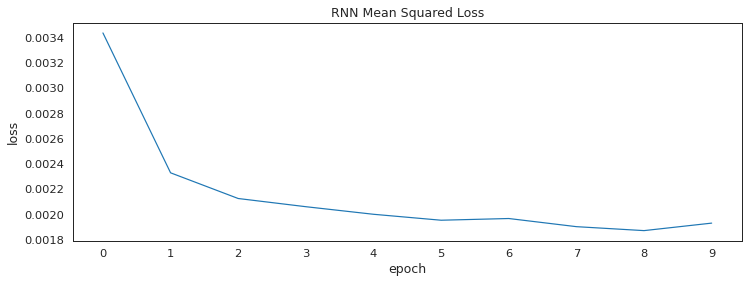

In [52]:
losses_RNN = RNN.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.title('RNN Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_RNN)),losses_RNN);

### Prediction

In [53]:
RNN_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    RNN_pred = RNN.predict(current_batch)[0]
    RNN_predictions_scaled.append(RNN_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[RNN_pred]],axis=1)

In [54]:
RNN_predictions = scaler.inverse_transform(RNN_predictions_scaled)

In [55]:
test_data['RNN_Predictions'] = RNN_predictions
test_data

,Active_Power,CNN_Predictions,RNN_Predictions
date_time,,,
2015-12-31 12:00:00,1797.3000,1862.7802,1523.4784
2015-12-31 13:00:00,1725.1000,1777.3194,1308.9765
2015-12-31 14:00:00,1721.2000,1731.0331,1090.5224
2015-12-31 15:00:00,1690.0000,1802.4419,1012.8386
2015-12-31 16:00:00,1785.3000,1763.6293,1010.1371
2015-12-31 17:00:00,1598.0000,1783.8515,1078.3575
2015-12-31 18:00:00,1700.5000,1696.5352,1283.6859
2015-12-31 19:00:00,2198.2000,1992.0340,1419.2411
2015-12-31 20:00:00,2082.7000,2017.6003,1368.5101


### Evaluation


In [57]:
mae = metrics.mean_absolute_error(true_pred,RNN_predictions)
mse = metrics.mean_squared_error(true_pred, RNN_predictions)
rmse = np.sqrt(metrics.mean_squared_error(true_pred, RNN_predictions))
r2_square = metrics.r2_score(true_pred, RNN_predictions)
print('Total Mean Absolute Error:', mae)
print('Total Mean Squared Error:', mse)
print('Total Root Mean Squared Error:', rmse)
print('Total R2 Square', r2_square)

Total Mean Absolute Error: 521.2879504347839
Total Mean Squared Error: 310879.588071369
Total Root Mean Squared Error: 557.5657701754735
Total R2 Square -6.626649593806261


### Vizulization of Result

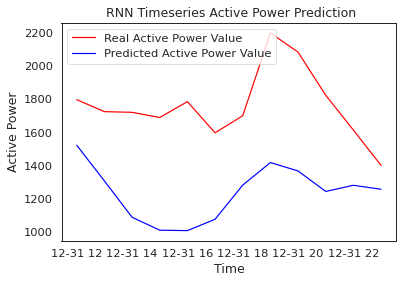

In [56]:
plt.plot(test_data.Active_Power, color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['RNN_Predictions'], color = 'blue', label = 'Predicted Active Power Value')
plt.title(' RNN Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### LSTM

Two Model Run which u prefer

Better but take more time to run

model = Sequential()

model.add(LSTM(units = 100,return_sequences = True,input_shape = (n_input, n_features)))
model.add(Dropout(0.25))

model.add(LSTM(units = 100,return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1))

In [60]:
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summary

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [62]:
early = EarlyStopping(mode = "min", patience = 7)
callbacks_list = [early]
    
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

### Run Model

In [64]:
history = model.fit_generator(generator,epochs = 5,callbacks = callbacks_list)

Epoch 1/5
86904/86904 [==============================] - 871s 10ms/step - loss: 0.0033 - mse: 0.0033
Epoch 2/5
86904/86904 [==============================] - 873s 10ms/step - loss: 0.0017 - mse: 0.0017
Epoch 3/5
86904/86904 [==============================] - 884s 10ms/step - loss: 0.0013 - mse: 0.0013
Epoch 4/5
86904/86904 [==============================] - 861s 10ms/step - loss: 0.0012 - mse: 0.0012
Epoch 5/5
86904/86904 [==============================] - 876s 10ms/step - loss: 0.0011 - mse: 0.0011


### Plot

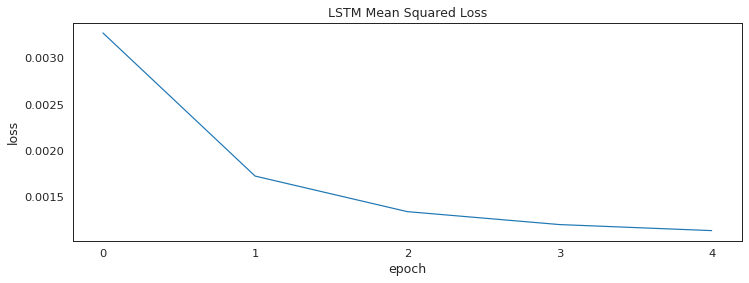

In [65]:
losses_LSTM = model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.title('LSTM Mean Squared Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(len(losses_LSTM)),losses_LSTM);

### Prediction


In [66]:
LSTM_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    LSTM_pred = model.predict(current_batch)[0]
    LSTM_predictions_scaled.append(LSTM_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[LSTM_pred]],axis=1)

In [67]:
LSTM_predictions = scaler.inverse_transform(LSTM_predictions_scaled)

## Evaluation


In [70]:
test_data['LSTM_predictions'] = LSTM_predictions
test_data

,Active_Power,CNN_Predictions,RNN_Predictions,LSTM_predictions
date_time,,,,
2015-12-31 12:00:00,1797.3000,1862.7802,1523.4784,1774.7888
2015-12-31 13:00:00,1725.1000,1777.3194,1308.9765,1688.4236
2015-12-31 14:00:00,1721.2000,1731.0331,1090.5224,1665.6605
2015-12-31 15:00:00,1690.0000,1802.4419,1012.8386,1673.2984
2015-12-31 16:00:00,1785.3000,1763.6293,1010.1371,1662.1879
2015-12-31 17:00:00,1598.0000,1783.8515,1078.3575,1624.4631
2015-12-31 18:00:00,1700.5000,1696.5352,1283.6859,1825.9227
2015-12-31 19:00:00,2198.2000,1992.0340,1419.2411,2050.5735
2015-12-31 20:00:00,2082.7000,2017.6003,1368.5101,1920.7039


In [72]:
mae = metrics.mean_absolute_error(true_pred,LSTM_predictions)
mse = metrics.mean_squared_error(true_pred, LSTM_predictions)
rmse = np.sqrt(metrics.mean_squared_error(true_pred, LSTM_predictions))
r2_square = metrics.r2_score(true_pred, LSTM_predictions)
print('Total Mean Absolute Error:', mae)
print('Total Mean Squared Error:', mse)
print('Total Root Mean Squared Error:', rmse)
print('Total R2 Square', r2_square)

Total Mean Absolute Error: 128.9766165807842
Total Mean Squared Error: 26799.842544247924
Total Root Mean Squared Error: 163.70657452969908
Total R2 Square 0.34253319903641455


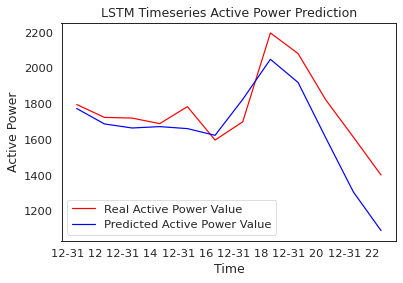

In [71]:
plt.plot(test_data.Active_Power, color = 'red', label = 'Real Active Power Value')
plt.plot(test_data['LSTM_predictions'], color = 'blue', label = 'Predicted Active Power Value')
plt.title('LSTM Timeseries Active Power Prediction')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.legend()
plt.show()

### ALL Model Predictions Comparision
